# Project Part 2 Solutions

## (a)

In [1]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]
file.files

['beta_old', 'N', 'Svc_0_PMF', 'Lc', 'Ic_0', 'gamma', 'L_observed']

In [2]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [3]:
def SIR1(t, Z, N, betas, gamma,alpha):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -(betas*alpha)*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [4]:
from random import seed
from random import random
def loss_func(alpha,node_index,N):
    initial_conditions = np.concatenate((S[node_index,:,:,9].flatten(), I[node_index,:,9], [R[node_index,9]]))
    soln = solve_ivp(SIR1, (t[9], t[29]), initial_conditions, args=(N, beta_old, gamma,alpha), t_eval=t[10:30])

    S[node_index, :, :, 10:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:30] = soln.y[16:20]
    R[node_index, 10:30] = soln.y[20]
    L[node_index, 10:30] = Lc@soln.y[16:20]
    Lpredicted=L[node_index, 10:30]
    mse= mean_squared_error(Lpredicted,L_observed[node_index,10:30])
    #breakpoint()
    return mse


In [5]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate((Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))



In [6]:
for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5,args=(node_index,N_node,),disp=False)
    #breakpoint()


In [7]:
dsort=np.argsort(alpha_predicted)

In [8]:
q=alpha_predicted[0]
a=loss_func(q,0,N[0])
print("MSE",a)
print("Alpha",q)

MSE 1.481544985440135e-05
Alpha 0.23352203369140603


In [9]:
sorted_alphas=np.array([alpha_predicted])
sorted_alphas.sort()
print("Nodes ranked by how high theyre alphas is",dsort)
print("The sorted alphas",sorted_alphas)

Nodes ranked by how high theyre alphas is [14 50 96 69 70 25 37 90 33 54 19 43  9 56 16 66 79 95  5 51 27 13 49  2
 93  0 15 48 44 98 92 64 53 20 58 86 84 10 61 38 72 75 30 31 85 21 23 12
 47 11 52 71 80 24 62 91  7  6 83 60 26 78  8 32  1 36 74 40 63 67 42 45
 41 94 73 68 28 22 81 89 65 57 87 17 59 76 18 34 35 77 55 29  4 99 46 82
  3 39 97 88]
The sorted alphas [[0.13437347 0.14959717 0.15996704 0.16158829 0.16303711 0.16851807
  0.17086182 0.17155762 0.17612305 0.17961426 0.18221436 0.18603516
  0.18708496 0.19025879 0.20031738 0.20330505 0.20419922 0.20612793
  0.20684509 0.2128418  0.21408691 0.2162323  0.21859131 0.22739868
  0.23042603 0.23352203 0.24160156 0.24464111 0.24894104 0.2512085
  0.25798035 0.25991821 0.26757812 0.26948242 0.27169952 0.27301636
  0.28005524 0.28283691 0.28662109 0.28800049 0.2930542  0.2992981
  0.29938965 0.30321045 0.30422821 0.30437622 0.30966797 0.31420898
  0.32382202 0.32966309 0.32988281 0.33074341 0.33313293 0.33355408
  0.3498291  0.35234375 

## (b)

In [10]:
sorted_alphas=sorted_alphas.flatten()


In [11]:
def before_alph(alpha):
    totalbfNPI=[]
    for old_index , node_index in zip(dsort,range(nb_nodes)):#dsort is the alphas ranked
        #breakpoint
        initial_conditions = np.concatenate((S[old_index,:,:,29].flatten(), I[old_index,:,29], [R[old_index,29]]))
        soln = solve_ivp(SIR1, (t[30], t[-1]), initial_conditions, args=(N[old_index], beta_old, gamma,alpha[node_index]), t_eval=t[30:200])
        #breakpoint
        R[node_index, 30:200] = soln.y[20]
        total=R[node_index,-1].sum()
        totalbfNPI.append(total)
       
    #breakpoint()
    
    return totalbfNPI

totalbfNPI1=before_alph(sorted_alphas)


In [12]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money
import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(sorted_alphas,alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")
    #plt.axis([0, 1, 0, 1])


S1 = np.zeros((nb_nodes, 4, 4, len(t)))
R1 = np.zeros((nb_nodes, len(t)))
print(S1.shape)
def total_recovered_difference(alpha_afterNPI):
    #dif=0
    totalafNPI=[]
    dif=0
    for old_index , node_index in zip(dsort,range(nb_nodes)):#dsort is the alphas ranked 
        initial_conditions = np.concatenate((S[old_index,:,:,29].flatten(), I[old_index,:,29], [R[old_index,29]]))
        soln1= solve_ivp(SIR1, (t[30], t[199]), initial_conditions, args=(N[old_index], beta_old, gamma,alpha_afterNPI[node_index]), t_eval=t[30:200])
       

        
        R1[node_index, 30:200] = soln1.y[20]
        total1=R1[node_index,-1].sum()
        totalafNPI.append(total1)
    for row in range(nb_nodes):
        dif+= -totalafNPI[row]+totalbfNPI1[row]
        #difference.append(dif)
        #a=difference.sum()
            
    
    
    
    return dif 


(100, 4, 4, 200)


### Policy #1

In [36]:
#i.
A1=[]
Newmoney=[]
for r in dsort: #dsort is the alphas ranked
    n=g_inv(alpha_predicted[r])
    nm=n+10000
    An=g(nm)
    m=g_inv(An)
    A1.append(An)
    Newmoney.append(m)

    

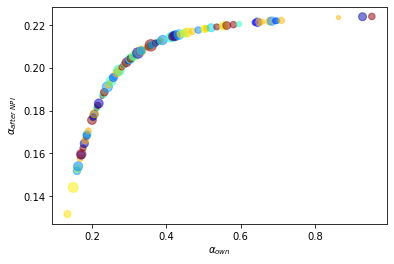

In [37]:
scatter_plot(A1)

In [38]:
#ii
print("the total recovered difference after 200 days is",total_recovered_difference(A1))

the total recovered difference after 200 days is 320303.9170014563


### Policy #2

In [39]:
nsum=N.sum()

alpha_predicted[14]
N_percent[14]*1000000

14172.517705220987

In [40]:
#i
N_percent=N/nsum
money=[]
for r in dsort:
    money.append(N_percent[r]*1000000)

A2=[]
Newmoney2=[]
for index,old_index in enumerate(dsort): #dsort is the ranked nodes 
    n=g_inv(alpha_predicted[old_index])
    nm=n+money[index]
    An=g(nm)
    m=g_inv(An)
    A2.append(An)
    Newmoney2.append(m)
    

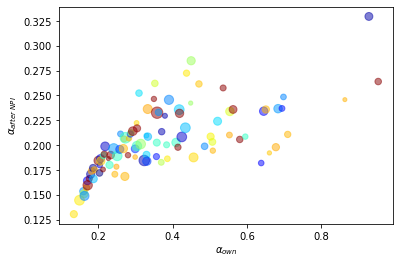

In [41]:
#i
import matplotlib.pyplot as plt
scatter_plot(A2)

In [42]:
#ii
print("the total recovered difference after 200 days is",total_recovered_difference(A2))

the total recovered difference after 200 days is 335849.78040623886


### Policy #3

In [43]:
from scipy import optimize

def policy_3(change_alpha):
    diff=0
    for alpha in alpha_predicted:
        diff+= g_inv(alpha-change_alpha) - g_inv(alpha)
    
    return (diff-1000000)**2 

change_alpha=fmin(policy_3,.1,disp=False)


cg_alpha=np.zeros((nb_nodes))       

i=0

for r in dsort:
    cg_alpha[i] = alpha_predicted[r]-change_alpha
    i+=1

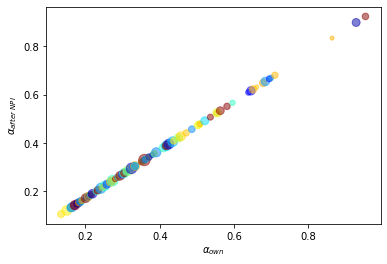

In [44]:
#i
scatter_plot(cg_alpha)

In [45]:
#ii
print("the total recovered difference after 200 days is",total_recovered_difference(cg_alpha))

the total recovered difference after 200 days is 62720.86363449564


### Policy #4 
Spend the budget proportional to each node’s average beta value weighted by the susceptible
population size in comorbidity and vulnerability compartments

In [46]:
((Svc_0[0]*beta_old).sum())/16

691.275

In [47]:
svcTbeta=[]
for a in range(nb_nodes):
    svcTbeta.append(((Svc_0[a]*beta_old).sum())/16)
total=sum(svcTbeta)
percentage=(svcTbeta/total)

In [48]:
#i
A4=[]
i=0
Newmoney4=[]
for r in dsort: #dsort is the ranked nodes 
    n=g_inv(alpha_predicted[r])
    nm=n+1000000*percentage[i]
    An=g(nm)
    m=g_inv(An)
    A4.append(An)
    Newmoney4.append(m)
    i+=1


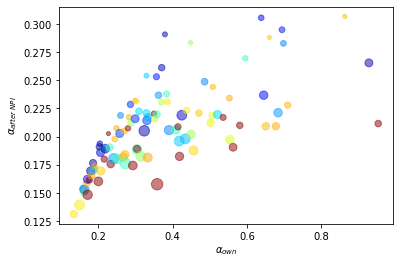

In [49]:
scatter_plot(A4)

In [50]:
#ii. 
print("the total recovered difference after 200 days is",total_recovered_difference(A4))

the total recovered difference after 200 days is 304529.2281408236


## (c)

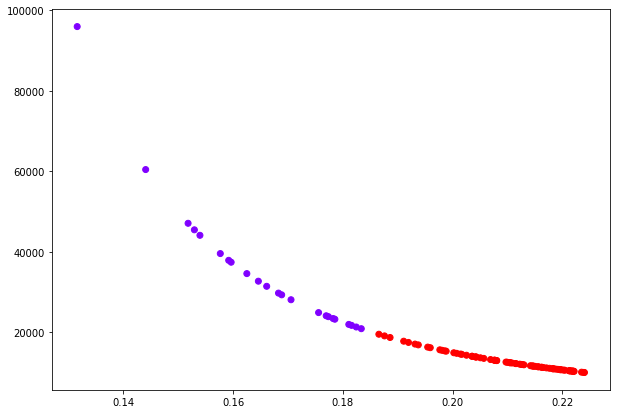

In [51]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

data=np.array(A1)
data2=np.array(Newmoney)

combined = np.vstack((data, data2)).T



cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(combined)
plt.figure(figsize=(10, 7))
plt.scatter(combined[:,0], combined[:,1],c=cluster.labels_, cmap='rainbow')




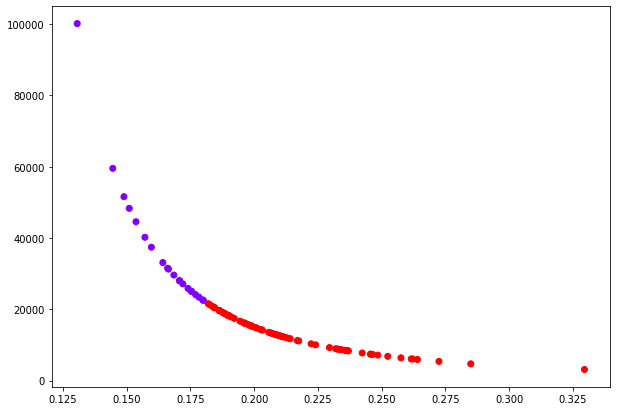

In [52]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

data=np.array(A2)
data2=np.array(Newmoney2)

combined = np.vstack((data, data2)).T



cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(combined)
plt.figure(figsize=(10, 7))
plt.scatter(combined[:,0], combined[:,1],c=cluster.labels_, cmap='rainbow')




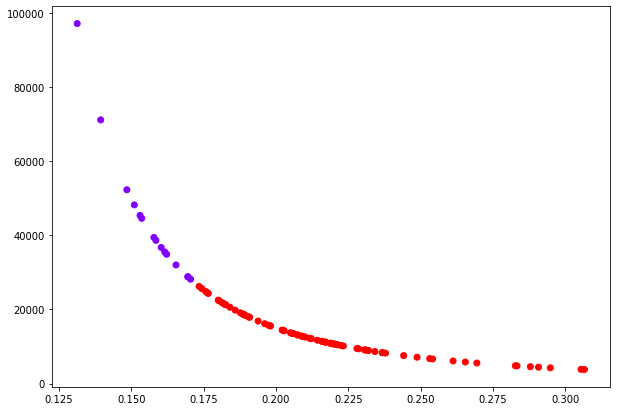

In [53]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

data=np.array(A4)
data2=np.array(Newmoney4)

combined = np.vstack((data, data2)).T



cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(combined)
plt.figure(figsize=(10, 7))
plt.scatter(combined[:,0], combined[:,1],c=cluster.labels_, cmap='rainbow')




### Policy 1

### Policy 2

### Policy 3

### Policy 4